In [45]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import re
from warnings import warn

from pyne import ace

from matplotlib import gridspec

from ASAPy import CovManipulation
from ASAPy.XsecSampler import map_groups_to_continuous
from ASAPy.XsecSampler import XsecSampler
from ASAPy import AceIO

from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy.linalg as LA

In [2]:
h = pd.HDFStore('scale_cov_252.h5', 'r')

In [63]:
u_d = h['92235/455/92235/455/std_dev'] # contains delayed fission yield vs e (only 1 corr)
u_t = h['92235/452/92235/452/std_dev'] # contains total fission yield vs e
u_p = h['92235/456/92235/456/std_dev'] # contains prompt fission yield vs e

u_d_t = h['92235/455/92235/452/std_dev'] # corr of d and t

In [57]:
u_d_c = h['92235/455/92235/455/corr'] # contains delayed fission yield vs e (only 1 corr)
u_t_c = h['92235/452/92235/452/corr'] # contains total fission yield vs e
u_p_c = h['92235/456/92235/456/corr'] # contains prompt fission yield vs e

u_d_t_c = h['92235/455/92235/452/corr'] # corr of d and t
# if p and d given:
#    sample from both add up to replace total
# if d and t given:
#    sample from d and t and set p = t-d
# if only p or only e given:
#    sample from w/e is given then use t as p+e
# if p and t given:
#    sample from just p then add the constant e to get t (assume p,t perfectly correlated since if you did t-p=d, can get negative values)
# if only t:
#    sample from t and adjust p accordingly since p dominates e
# if all 3 given:
#    skip due to ambiguity unless a correlation is provided

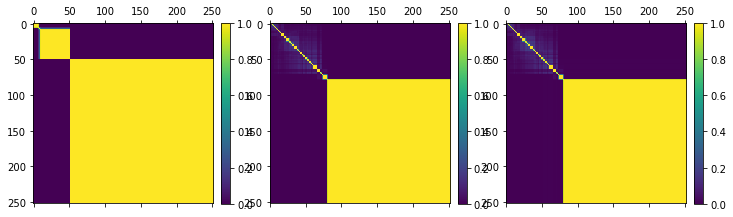

In [69]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 6))
cax = ax[0].matshow(u_d_c/1000)
fig.colorbar(cax, ax=ax[0], fraction=0.046, pad=0.04)
ax[1].matshow(u_p_c/1000)
plt.colorbar(cax, ax=ax[1], fraction=0.046, pad=0.04)
ax[2].matshow(u_t_c/1000)
plt.colorbar(cax, ax=ax[2], fraction=0.046, pad=0.04)



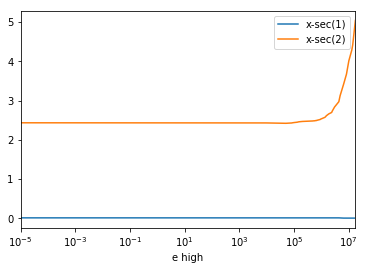

In [66]:
ax=u_d_t.sort_values('e high').plot(x='e high', y='x-sec(1)', logx=True)
u_d_t.sort_values('e high').plot(x='e high', y='x-sec(2)', logx=True, ax=ax)

In [3]:
h_keys = h.keys()

In [4]:
len(h_keys)

9126

In [21]:
re.findall('74184/102.*/', ' '.join(h_keys))

['74184/102/corr /74184/2/74184/102/std_dev /74184/2/74184/2/corr /74184/2/74184/2/std_dev /74184/102/74184/1/corr /74184/102/74184/1/std_dev /74184/102/74184/102/corr /74184/102/74184/102/std_dev /74184/1/74184/1/corr /74184/1/74184/1/std_dev /74183/4/74183/4/corr /74183/4/74183/4/std_dev /74183/2/74183/1/corr /74183/2/74183/1/std_dev /74183/2/74183/102/corr /74183/2/74183/102/std_dev /74183/2/74183/2/corr /74183/2/74183/2/std_dev /74183/102/74183/1/corr /74183/102/74183/1/std_dev /74183/102/74183/102/corr /74183/102/74183/102/std_dev /74183/1/74183/1/corr /74183/1/74183/1/std_dev /74182/4/74182/4/corr /74182/4/74182/4/std_dev /74182/2/74182/1/corr /74182/2/74182/1/std_dev /74182/2/74182/102/corr /74182/2/74182/102/std_dev /74182/2/74182/2/corr /74182/2/74182/2/std_dev /74182/102/74182/1/corr /74182/102/74182/1/std_dev /74182/102/74182/102/corr /74182/102/74182/102/std_dev /74182/1/74182/1/corr /74182/1/74182/1/std_dev /74180/4/74180/4/corr /74180/4/74180/4/std_dev /74180/2/74180/1/co

In [3]:
#libFile = ace.Library('/Users/veeshy/MCNP6/MCNP_DATA/xdata/endf71x/W/74184.710nc')
libFile = ace.Library('./xe135m/Xe135m-n.ace.txt')
libFile.read()
libFile.find_table('54135')
a = libFile.tables[list(libFile.tables.keys())[0]]

e = a.energy
st = a.find_reaction(102).sigma

In [4]:
w184_102_std = h['74184/102/74184/102/std_dev']

x135m_102_std = h['5459/102/5459/102/std_dev']
x135_102_std = h['54135/102/54135/102/std_dev']

In [6]:
libFile_xe135 = ace.Library('/Users/veeshy/MCNP6/MCNP_DATA/xdata/endf71x/Xe/54135.710nc')
libFile_xe135.read()
libFile_xe135.find_table('54135')
a_xe135 = libFile_xe135.tables[list(libFile_xe135.tables.keys())[0]]

e_135 = a_xe135.energy
st_135 = a_xe135.find_reaction(102).sigma


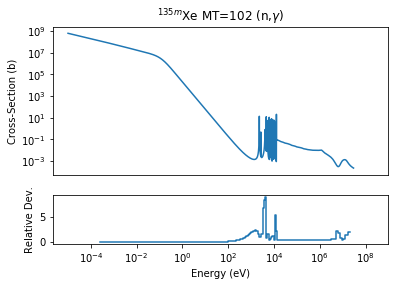

In [41]:
fig = plt.figure(figsize=(6,4))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 

ax = fig.add_subplot(gs[0])
ax.loglog(e*1e6, st)
#ax.set_xlim([1.78e-4, 1.9e-4])
#ax.set_ylim([1e-3, 1e3])
ax.get_xaxis().set_visible(False)
ax.set_ylabel('Cross-Section (b)')
ax.set_title('$^{135m}$Xe MT=102 (n,$\gamma$)')

ax = fig.add_subplot(gs[1], sharex=ax) # the above ax
ax.plot(x135m_102_std['e high'],  x135m_102_std['rel.s.d.(1)'], drawstyle='steps-mid')
ax.set_xscale('log')
ax.set_xlabel('Energy (eV)')
ax.set_ylabel('Relative Dev.')

#ax.set_xlim([1e-4, 10])
#ax.set_ylim([0, 0.15]);
fig.savefig('xe_135m_102.eps') 
#ax.set_xlim([1e2, 1e3])

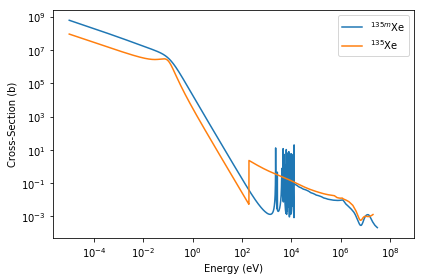

In [42]:
fig, ax = plt.subplots()

ax.loglog(e*1e6, st, label='$^{135m}$Xe')
ax.loglog(e_135*1e6, st_135, label='$^{135}$Xe')

ax.set_ylabel('Cross-Section (b)')
ax.set_xlabel('Energy (eV)')
ax.legend()
plt.tight_layout()
fig.savefig('xe_vs_m_mt=102.eps')



In [5]:
w = XsecSampler(h, 5459, 102)

eig_replace: got eig -0.00776673221481
eig_replace: created eig (9.99999866013e-09+0j)


In [9]:
sample_df = w.sample('norm', 500, return_relative=False, remove_neg=False)

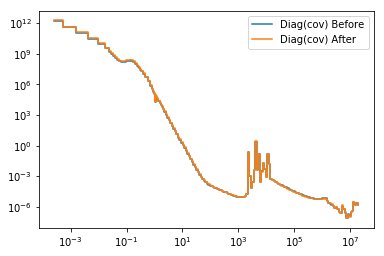

In [9]:
plt.loglog(x135m_102_std['e high'], x135m_102_std['s.d.(1)']**2, drawstyle='steps-mid', label='Diag(cov) Before')
plt.loglog(x135m_102_std['e high'], np.diag(np.cov(sample_df)), drawstyle='steps-mid', label='Diag(cov) After')

plt.legend()

In [22]:
sample_df_log = w.sample('lognorm', 500, return_relative=True, remove_neg=False)

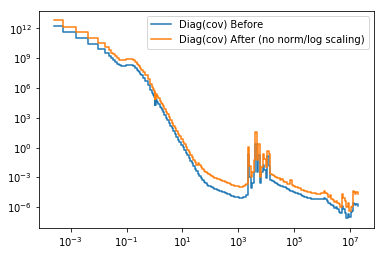

In [13]:
plt.loglog(x135m_102_std['e high'], x135m_102_std['s.d.(1)']**2, drawstyle='steps-mid', label='Diag(cov) Before')
plt.loglog(x135m_102_std['e high'], np.diag(np.cov(sample_df_log)), drawstyle='steps-mid', label='Diag(cov) After (no norm/log scaling)')

plt.legend()

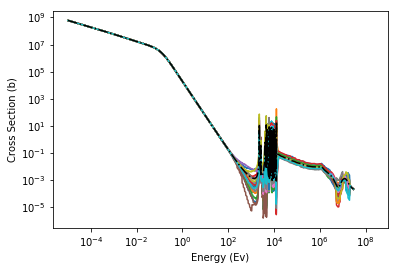

In [26]:
fig, ax = plt.subplots()
for i in range(30):
    ax.loglog(e*1e6, map_groups_to_continuous(e, x135m_102_std['e high'], sample_df_log[i], 
                                              min_e=x135m_102_std['e low'].min()-1) * st, label=i);

ax.loglog(e*1e6, st, linestyle='-.', color='k')
#ax.set_xlim([180, 190])
#ax.set_xscale('linear')
#ax.set_yscale('linear')
#plt.legend()

ax.set_xlabel('Energy (Ev)')
ax.set_ylabel('Cross Section (b)')

plt.savefig('30_xe135m_mt=102.eps')

In [11]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

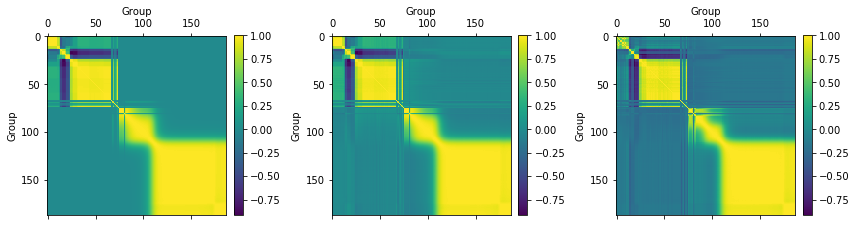

In [19]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 6))
cax = ax[0].matshow(w.corr_df.values)
fig.colorbar(cax, ax=ax[0], fraction=0.046, pad=0.04)
ax[0].set_xlabel('Group')
ax[0].xaxis.set_label_position('top')
ax[0].set_ylabel('Group')

ax[1].matshow(np.corrcoef(sample_df))
fig.colorbar(cax, ax=ax[1], fraction=0.046, pad=0.04)
ax[1].set_xlabel('Group')
ax[1].xaxis.set_label_position('top')
ax[1].set_ylabel('Group')

ax[2].matshow(np.corrcoef(sample_df_log))
fig.colorbar(cax, ax=ax[2], fraction=0.046, pad=0.04)
ax[2].set_xlabel('Group')
ax[2].xaxis.set_label_position('top')
ax[2].set_ylabel('Group')

fig.tight_layout()
fig.savefig('correlations_out.eps', bbox_inches='tight')

In [5]:
xsec = XsecSampler(h, 74184, 102)
sample_df = xsec.sample('norm', 5, allow_singular=True, return_relative=True)

ace_path = '/Users/veeshy/MCNP6/MCNP_DATA/xdata/endf71x/W/74184.710nc'
ae = AceIO.AceEditor(ace_path)
e = ae.energy
original_sigma = ae.get_sigma(102)

# sample_df contains relative values (sampled / mean) which are then multiplied by the actual continuous xsec and written to an ace file
for idx, col in sample_df.iteritems():
    # set the sigma
    ae.set_sigma(102, map_groups_to_continuous(e, x135m_102_std['e high'], col, 
                                               min_e=x135m_102_stdw184_102_std['e low'].min()) * original_sigma)
    ae.apply_sum_rules()
    
    w = AceIO.WriteAce(ace_path)
    w.replace_array(original_sigma, ae.get_sigma(102))
    w.write_ace('/Users/veeshy/MCNP6/MCNP_DATA/xdata/endf71x/W/rand_norm/74184_{0}.710nc'.format(idx))
    
sample_df.to_csv('/Users/veeshy/MCNP6/MCNP_DATA/xdata/endf71x/W/rand_norm/relative_xsec_groups.csv')

KeyError: 'No object named 74184/102/74184/102/std_dev in the file'

In [40]:
xsec = XsecSampler(h, 74184, 102)
sample_df = xsec.sample('lhs', 500, return_relative=True)

ace_path = '/Users/veeshy/MCNP6/MCNP_DATA/xdata/endf71x/W/74184.710nc'
ae = AceIO.AceEditor(ace_path)
e = ae.energy
original_sigma = ae.get_sigma(102)

# sample_df contains relative values (sampled / mean) which are then multiplied by the actual continuous xsec and written to an ace file
for idx, col in sample_df.iteritems():
    # set the sigma
    ae.set_sigma(102, map_groups_to_continuous(e, w184_102_std['e high'], col, 
                                               min_e=w184_102_std['e low'].min()) * original_sigma)
    ae.apply_sum_rules()
    
    w = AceIO.WriteAce(ace_path)
    w.replace_array(original_sigma, ae.get_sigma(102))
    w.write_ace('/Users/veeshy/MCNP6/MCNP_DATA/xdata/endf71x/W/rand_lhs/74184_{0}.710nc'.format(idx))



min eig after removing neg 9.99996578209e-09
min eig desired 1e-08
min eig after removing neg 9.9999977752e-09
min eig desired 1e-08
Min eig of cov: 9.999997775200921e-09


FileNotFoundError: [Errno 2] No such file or directory: '/Users/veeshy/MCNP6/MCNP_DATA/xdata/endf71x/W/rand_lh/relative_xsec_groups.csv'

In [41]:
sample_df.to_csv('/Users/veeshy/MCNP6/MCNP_DATA/xdata/endf71x/W/rand_lhs/relative_xsec_groups.csv')

In [55]:
from scipy import random as sr
from scipy import stats as ss
from scipy.stats.distributions import norm, lognorm
from numpy.random import lognormal as nplognormal

In [37]:
uni_samples = sr.uniform(size=5000)

In [91]:
mean = 1e-3
sigma = 1

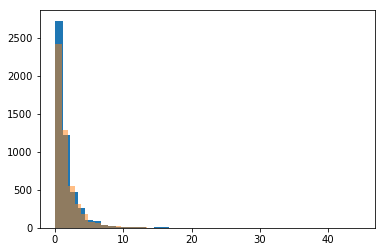

In [92]:
norm_samples = lognorm.ppf(uni_samples, scale=np.exp(mean), s=sigma)

plt.hist(norm_samples, bins=40);
#plt.xlim([0, 1000])

norm_samples = nplognormal(mean=mean, sigma=sigma, size=5000)

plt.hist(norm_samples, bins=40, alpha=0.5);